# Reducing discrepancy using retry strategy

## Initial Imports and Set-up


In [18]:
%matplotlib inline

import pylab
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import time
def sign(a):
    if a>=0:
        return 1.
    elif a<0:
        return -1.
    else:
        return None
    

In [369]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['lines.linewidth'] = 2.
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Proxima Nova']})
# # rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)


In [20]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


## Defining the data structure

In [21]:
# a typical node will have empty leaves attribute while the root tree will have the global leaves attribute
# to avoid long expressions, I used names like lchild, lcount to denote the left child, left count etc.

class Node(object):
    def __init__(self, lval=None, rval=None, isLeaf=False, isRoot=False):
        self.lval = lval
        self.rval = rval
        if self.lval != None and self.rval != None:
            self.mval = 0.5* (lval + rval)
        else:
            self.mval = None
        self.lcount = 0
        self.rcount = 0
        self.isLeaf = isLeaf 
        self.isRoot = isRoot
        self.lchild = None
        self.rchild = None
        self.rvs = []
        self.leaves = []
        self.parent = None
        self.worst_interval = None
        
    def __str__(self, level=0):
        ret = "\t"*level+str(self.mval)+';'+str(self.lcount)+':'+str(self.rcount)+'\n'
        for child in [self.lchild, self.rchild]:
            if child != None and level <=3:
                ret += child.__str__(level+1)
        return ret

## Defining the functions

In [91]:
def insert(node, root, num):
    ''' 
    this inserts a given number at leaf level in the root tree by 
    iteratively going down the nodes and comparing to their mval, 
    less than mval goes to the 'lchild' and increments 'lcount' of that
    node by 1, and otherwise, the number is passed to the 'rchild'
    and node's 'rcount' is incremented by 1.

    root tree is passed to keep track of the leaves at the global level
    '''
    if (not root.isRoot):
        raise AssertionError("No root tree. Please provide the root tree as well.")
    elif node.isLeaf == True:
        node.rvs.append(num)
        root.rvs.append(num) # to maintain a global list of all random numbers so far
    elif node.lchild == None or node.rchild == None:
        raise AssertionError("No children for the non-leaf node.")
    elif num < node.mval:
        node.lcount += 1
        insert(node.lchild, root, num)
    else:
        node.rcount += 1
        insert(node.rchild, root, num)
def update_tree(root):
    """
    this updates the tree by splitting all leaves into two. It clears the root leaves
    and each update_leaf adds two leaves to root.leaves
    """
    if ( not root.isRoot):
        raise AssertionError("No root tree. Please provide the root tree as well.")

    old_leaves = root.leaves
    root.leaves = [] # empty the leaves list
    
    for leaf in old_leaves:
        update_leaf(root, leaf) # each update will add two leaves in root.leaves

def update_leaf(root, leaf):
    """
    this splits a leaf of the root tree in two parts, and appends to root.leaves
    the new leaves.
    """
    if not root.isRoot:
        raise AssertionError("No root tree. Please provide the root tree as well.")
    lval = leaf.lval
    rval = leaf.rval
    mval = leaf.mval
    rvs = leaf.rvs

    if leaf.lchild != None or leaf.rchild != None:
        raise AssertionError("This leaf/node already has children. Can not add children.")
    elif (not leaf.isLeaf):
        raise AssertionError("This is not the leaf level, can not update it.")
    else:
        lchild = Node(lval = lval, rval = mval, isLeaf=True)
        rchild = Node(lval = mval, rval = rval, isLeaf=True)
        
        assign_children_rvs(root, leaf, lchild, rchild, rvs)

def assign_children_rvs(root, leaf, lchild, rchild, rvs):
    """
    this transfers the random variables of a (leaf) node to its children.
    """
    for rv in rvs:
        if rv < lchild.rval: # which is same as rv<leaf.mval
            lchild.rvs.append(rv)
        else:
            rchild.rvs.append(rv)
    lchild.parent = leaf
    rchild.parent = leaf

    leaf.lchild = lchild
    leaf.rchild = rchild
    leaf.lcount = len(lchild.rvs)
    leaf.rcount = len(rchild.rvs)
    leaf.isLeaf = False        
    root.leaves.append(leaf.lchild)
    root.leaves.append(leaf.rchild)

In [23]:
def initialize_tree(depth=3):
    '''
    creating a tree with certain depth to begin with. We need a tree with leaves for the code to work.
    '''
    root = Node(lval=0, rval=1, isLeaf=False, isRoot=True)
    root.lchild = Node(lval=0, rval=0.5, isLeaf=True, isRoot=False)
    root.rchild = Node(lval=0.5, rval=1, isLeaf=True, isRoot=False)
    root.lchild.parent = root
    root.rchild.parent = root
    root.leaves.append(root.lchild)
    root.leaves.append(root.rchild)
    for _ in range(depth-1):
        update_tree(root)
    return root

def update_count(count, num, interval):
    '''
    updates the number of points inside a d-dimensional interval d by 2
    '''
    ind = True
    for j in range(len(interval)): # == interval.shape[0]
        if num[j] < interval[j][0] or num[j] >= interval[j][1]:
            ind = False
    if (ind):
        count += 1
    return count

def pretty_histogram(x, col='blue', yll=0., yul=1.):
    '''
    to make histograms visually more appealing
    '''
    n, bins, patches = plt.hist(x, 50, normed=1, facecolor=col, alpha=0.75)

    # add a 'best fit' line
    y = [1.]*bins.size
    l = plt.plot(bins, y, 'r--', linewidth=1)

    plt.xlabel('x')
    plt.ylabel('Probability')
    plt.axis([0, 1, yll, yul])
    plt.grid(True)

In [24]:
def strategic_insert_and_discrepancy(strategy, rate_activation, num_unif, root, random_num, depth, 
                                  tilt=0., eta=1., factor=10., verbose=False):
    '''
    this uses the rate to first compute the adjusted rate and then use this rate 
    and the given number to get a number from retry strategy which is inserted in the tree.

    Note that this function should use depth = log2(len(root.leaves))
    and rate = 1. (the initial rate)
    '''
    if (not root.isRoot):
        raise AssertionError("No root tree. Please provide the root tree as well.")
        
    adjusted_rate = new_rate_function(activation=rate_activation, node=root, 
                                      num=random_num, depth=depth, tilt=tilt, eta=eta, factor=factor, verbose=verbose)
    extra_unif, num_to_insert = strategy(root=root, depth=depth, num=random_num, rate=adjusted_rate, eta=eta,
                                        activation=activation)
    if verbose:
        print adjusted_rate, random_num, num_to_insert
    insert(root, root, num_to_insert)
    return num_unif+extra_unif, num_to_insert, len(root.rvs)

def new_rate_function(activation, node, num, depth, tilt, eta, factor = 10., verbose=False):
    '''
    compute rate (Lambda in the paper) by iteratively going down a tree 
    and seeing the balance at each level. This returns the rate when
    the function has reached the leaf level.
    '''
    if node.isLeaf == True:
        return 1+(tilt * eta / factor / depth)
    else:
        extra_tilt = activation(node.lcount-node.rcount) # positive when lcount is more
        if num<node.mval: 
            extra_tilt *= -1 # sign flip = discourage a number if lcount was more, encourage otherwise
            tilt += extra_tilt
            if verbose:
                print 'tilt:%d, num:%.4f, mval:%.4f, l:%d, r:%d'%(tilt, num, node.mval, node.lcount, node.rcount)
            return new_rate_function(activation, node.lchild, num, depth,  tilt, eta, factor, verbose)
        else:
            tilt += extra_tilt
            if verbose:
                print 'tilt:%d, num:%.4f, mval:%.4f, l:%d, r:%d'%(tilt, num, node.mval, node.lcount, node.rcount)
            return new_rate_function(activation, node.rchild, num, depth,  tilt, eta, factor, verbose)

In [217]:
# Strategies:

def mc(root, num, depth, rate, eta, activation):
    return 1., num

def retry(root, num, depth, rate, eta, activation):
    '''
    retry strategy as given in the paper.
    '''
    x = np.random.rand()
    if x <= rate-eta/2:
        return 2., num
    else:
        return 3., np.random.rand()
    
def greedy_retry(root, num, depth, rate, eta, activation):
    '''
    retry strategy as given in the paper.
    '''    
    # Binary decision
    if rate>1: 
        return 1., num
    else:
        return 2., np.random.rand()   

def two_choice(root, num, depth, rate, eta, activation):
    '''
    retry strategy as given in the paper.
    '''
    new_num = np.random.rand()
    new_rate = new_rate_function(activation, root, new_num, depth, tilt=0., eta=eta, factor = 10., verbose=False)   
    num_to_insert = num
    if new_rate > rate:
        num_to_insert = new_num
    return 2., num_to_insert
    
def keep_retrying(root, num, depth, rate, eta, activation):
    '''
    keep retrying till you find something meaningful with rate >1
    '''
    n_rate = rate
    n_unif = 1.
    if n_rate >= 1:
        return n_unif, num
    else:
        while(n_rate < 1. and n_unif < 100):
            new_num = np.random.rand()
            n_rate = new_rate_function(activation, root, new_num, depth, tilt=0., eta=eta, factor = 10., verbose=False)   
            n_unif += 1.
        return n_unif, new_num

In [26]:
# Activation:

def signed(x):
    return sign(x)

def tanh(x):
    return np.tanh(x/100.)

def volume(interval):
    return np.prod(np.asarray([(interval[j][1]-interval[j][0]) for j in range(len(interval))]))


## Main Simulation : Uniform Distribution

In [27]:
def num_balls(growth, initial_depth, num_depths):
    balls = 0.
    for i in range(num_depths):
        j = initial_depth+i
        balls += growth(j)
        
    return balls

def linear_growth(j):
    return 2**j

def fast_growth(j):
    return j*2**j

def faster_growth(j):
    return j**2 * 2**j


In [ ]:
##### interval1 = [[0, 0.5]]
v1 = volume(interval1)
interval2 = [[1./3, 2./3]]
v2 = volume(interval2)


np.random.seed(685940)
initial_depth = 3
final_depth = 18

growth = linear_growth
activation = signed

num_depths = final_depth-initial_depth + 1
num_exp = 5

N = final_depth+1

TOTAL_RVS = num_balls(growth, initial_depth, num_depths)

# For keep retrying strategy with upper threshold 100 per iteration
k_dis = np.zeros((num_exp, TOTAL_RVS))
k_dis2 = np.zeros((num_exp, TOTAL_RVS))


my_dis = np.zeros((num_exp, TOTAL_RVS))
t_dis = np.zeros((num_exp, TOTAL_RVS))
u_dis = np.zeros((num_exp, TOTAL_RVS))
g_dis = np.zeros((num_exp, TOTAL_RVS))

my_dis2 = np.zeros((num_exp, TOTAL_RVS))
t_dis2 = np.zeros((num_exp, TOTAL_RVS))
u_dis2 = np.zeros((num_exp, TOTAL_RVS))
g_dis2 = np.zeros((num_exp, TOTAL_RVS))

my_unif = np.zeros((num_exp, TOTAL_RVS))
# t_unif = np.zeros((num_exp, N*2**(N+1)))
u_unif = np.zeros((num_exp, N*2**(N+1)))
# g_unif = np.zeros((num_exp, N*2**(N+1)))
k_unif = np.zeros((num_exp, TOTAL_RVS))

n_dis = np.zeros((num_exp, TOTAL_RVS))

# Worst case
r_w = np.zeros((num_exp, num_depths))
g_w = np.zeros((num_exp, num_depths))
t_w = np.zeros((num_exp, num_depths))
mc_w = np.zeros((num_exp, num_depths))
k_w = np.zeros((num_exp, num_depths))
n_w = np.zeros((num_exp, num_depths))

for exp in range(num_exp):
    print '\n ========= Experiment Number:%d =========' % exp
    root = initialize_tree(initial_depth)
    
#     r_root = [initialize_tree(initial_depth) for _ in range(c)]
    
    g_root = initialize_tree(initial_depth) # to see the greedy

    m_root = initialize_tree(initial_depth) # MC
        
    t_root = initialize_tree(initial_depth) # to see two choice greedy

    k_root = initialize_tree(initial_depth) # to see two choice greedy

    urvs = []
    urvs = np.asarray(urvs)
        
    count = 0.
    u_count = 0.
    g_count = 0.
    t_count = 0.
    k_count = 0.

    count2 = 0.
    u_count2 = 0.
    g_count2 = 0.
    t_count2 = 0.
    k_count2 = 0.

    my_u_count = 0.
    u_u_count = 0.
    g_u_count = 0.
    t_u_count = 0.
    k_u_count = 0.
    
    idx = 0
    total_g = 0
    total_n = 0
    total_u = 0
    total_t = 0
    total_k = 0
    
    t0 = time.time()
    for i in range(num_depths):
        j = initial_depth+i
        n0 = growth(j)

        rvs = np.random.rand(n0)
        rvs2 = np.random.rand(n0)
        urvs = np.concatenate((urvs, rvs))

        for rv, rv2 in zip(rvs, rvs2):

            my_u_count, my_num, total_n = strategic_insert_and_discrepancy(strategy = retry, rate_activation= activation, 
                                    num_unif = my_u_count, root = root, random_num = rv,  depth = j, 
                                    tilt=0., factor=10., verbose=False, eta=1.)
            count = update_count(count, [my_num], interval1)
            count2 = update_count(count2, [my_num], interval2)
            my_unif[exp, idx] = my_u_count
            
            _, t_num, total_t = strategic_insert_and_discrepancy(strategy = two_choice, rate_activation= activation, 
                                    num_unif = t_u_count, root = t_root, random_num = rv,  depth = j, 
                                    tilt=0., factor=10., verbose=False, eta=1.)
            t_count = update_count(t_count, [t_num], interval1)
            t_count2 = update_count(t_count2, [t_num], interval2)
#             t_unif[exp, idx] = t_u_count
            
            _, g_num, total_g = strategic_insert_and_discrepancy(strategy = greedy_retry, rate_activation= activation, 
                                    num_unif = g_u_count, root = g_root, random_num = rv,  depth = j, 
                                    tilt=0., factor=10., verbose=False, eta=1.)
            g_count = update_count(g_count, [g_num], interval1)
            g_count2 = update_count(g_count2, [g_num], interval2)
#             g_unif[exp, idx] = g_u_count
            
            # Monte Carlo
#             u_u_count += 1
#             u_num = rv
            u_u_count, u_num, total_u = strategic_insert_and_discrepancy(strategy = mc, rate_activation= activation, 
                                    num_unif = u_u_count, root = m_root, random_num = rv,  depth = j, 
                                    tilt=0., factor=10., verbose=False, eta=1.)

            u_count = update_count(u_count, [u_num], interval1)
            u_count2 = update_count(u_count2, [u_num], interval2)
            u_unif[exp, idx] = u_u_count
            
            
            k_u_count, k_num, total_k = strategic_insert_and_discrepancy(strategy = keep_retrying, rate_activation= activation, 
                                    num_unif = k_u_count, root = k_root, random_num = rv,  depth = j, 
                                    tilt=0., factor=10., verbose=False, eta=1.)
            k_unif[exp, idx] = k_u_count
            k_count = update_count(k_count, [k_num], interval1)
            k_count2 = update_count(k_count2, [k_num], interval2)

            my_dis[exp, idx] = np.abs(float(count)/total_n-v1)
            t_dis[exp, idx] = np.abs(float(t_count)/total_t-v1)
            g_dis[exp, idx] = np.abs(float(g_count)/total_g-v1)
            u_dis[exp, idx] = np.abs(float(u_count)/total_u-v1)
            k_dis[exp, idx] = np.abs(float(k_count)/total_k-v1)
            
            my_dis2[exp, idx] = np.abs(float(count2)/total_n-v2)
            t_dis2[exp, idx] = np.abs(float(t_count2)/total_t-v2)
            g_dis2[exp, idx] = np.abs(float(g_count2)/total_g-v2)
            u_dis2[exp, idx] = np.abs(float(u_count2)/total_u-v2)
            k_dis2[exp, idx] = np.abs(float(k_count2)/total_k-v2)

            n_dis[exp, idx] = total_n

            
            idx += 1
            
        update_tree(root)
        update_tree(t_root)
        update_tree(g_root)
        update_tree(m_root)
        update_tree(k_root)
        
        tree_traversal_for_worst_case(depth = j+1, tree=root)
        tree_traversal_for_worst_case(depth = j+1, tree=g_root)
        tree_traversal_for_worst_case(depth = j+1, tree=t_root)
        tree_traversal_for_worst_case(depth = j+1, tree=m_root)
        tree_traversal_for_worst_case(depth = j+1, tree=k_root)

        
        r_w[exp, i] = root.worst_interval[0]
        g_w[exp, i] = g_root.worst_interval[0]
        t_w[exp, i] = t_root.worst_interval[0]
        mc_w[exp, i] = m_root.worst_interval[0]
        n_w[exp, i] = n_dis[exp, idx-1]
        k_w[exp, i] = k_root.worst_interval[0]


#         for e_root in r_root:
#             update_tree(e_root)

        t1 = time.time()
        t = t1-t0
        t0 = t1
        print 'level %d -- n: %d, my_dis: %f, g_dis: %f, t_dis: %f, u_dis: %f, k_dis: %f, time taken: %.2f' % (j, 
                                                                    n_dis[exp, idx-1], 
                                                                    my_dis[exp, idx-1], 
                                                                    g_dis[exp, idx-1],
                                                                    t_dis[exp, idx-1],
                                                                    u_dis[exp, idx-1],
                                                                    k_dis[exp, idx-1], t)
#         print (r_dis[:, exp, idx-1], C)
#         print urvs.size, len(root.rvs)
#         assert (urvs.size == len(root.rvs))

In [227]:
# Averaging across experiments

# getting rid of n = 1
my_dis = my_dis[:, 1:idx]
u_dis = u_dis[:, 1:idx]
g_dis = g_dis[:, 1:idx]
t_dis = t_dis[:, 1:idx]
n_dis = n_dis[:, 1:idx]

# r_dis = r_dis[:, :, 1:idx]

k_dis = k_dis[:, 1:idx]

# Averaging
# avg_r_dis = np.mean(r_dis, axis=1)

avg_my_dis = np.mean(my_dis, axis=0)
avg_u_dis = np.mean(u_dis, axis=0)
avg_t_dis = np.mean(t_dis, axis=0)
avg_g_dis = np.mean(g_dis, axis=0)
avg_n_dis = np.mean(n_dis, axis=0)

avg_k_dis = np.mean(k_dis, axis=0)

# Round 2
my_dis2 = my_dis2[:, 1:idx]
u_dis2 = u_dis2[:, 1:idx]
g_dis2 = g_dis2[:, 1:idx]
t_dis2 = t_dis2[:, 1:idx]

# r_dis2 = r_dis2[:, :, 1:idx]
k_dis2 = k_dis2[:, 1:idx]

# avg_r_dis2 = np.mean(r_dis2, axis=1)

avg_my_dis2 = np.mean(my_dis2, axis=0)
avg_u_dis2 = np.mean(u_dis2, axis=0)
avg_t_dis2 = np.mean(t_dis2, axis=0)
avg_g_dis2 = np.mean(g_dis2, axis=0)
avg_n_dis2 = np.mean(n_dis, axis=0)

avg_k_dis2 = np.mean(k_dis2, axis=0)

my_unif = my_unif[:, 1:idx]
# u_unif = u_unif[:, 1:idx]
# g_unif = g_unif[:, 1:idx]
# t_unif = t_unif[:, 1:idx]
k_unif = k_unif[:, 1:idx]

avg_my_unif  = np.mean(my_unif, axis=0)
# avg_g_unif = np.mean(g_unif, axis=0)
# avg_t_unif = np.mean(t_unif, axis=0)
# avg_u_unif = np.mean(u_unif, axis=0)
avg_k_unif = np.mean(k_unif, axis=0)


avg_r_w = np.mean(r_w, axis = 0)
avg_g_w = np.mean(g_w, axis = 0)
avg_t_w = np.mean(t_w, axis = 0)
avg_m_w = np.mean(mc_w, axis = 0)
avg_k_w = np.mean(k_w, axis = 0)

avg_n_w = np.mean(n_w, axis = 0)

In [256]:
std_r_w = np.std(r_w, axis = 0)
std_g_w = np.std(g_w, axis = 0)
std_t_w = np.std(t_w, axis = 0)
std_m_w = np.std(mc_w, axis = 0)
std_k_w = np.std(k_w, axis = 0)

std_my_dis = np.std(my_dis, axis=0)
std_u_dis = np.std(u_dis, axis=0)
std_t_dis = np.std(t_dis, axis=0)
std_g_dis = np.std(g_dis, axis=0)
std_k_dis = np.std(g_dis, axis=0)

std_my_dis2 = np.std(my_dis2, axis=0)
std_u_dis2 = np.std(u_dis2, axis=0)
std_t_dis2 = np.std(t_dis2, axis=0)
std_g_dis2 = np.std(g_dis2, axis=0)
std_k_dis2 = np.std(g_dis2, axis=0)

## Plots

In [372]:
import pickle

with open('1d_worst_case.pickle', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump([r_w, g_w, t_w, k_w, mc_w, n_w,
                root.rvs, g_root.rvs, t_root.rvs, avg_my_dis, avg_u_dis, 
                 avg_g_dis, avg_t_dis, avg_my_dis2, avg_u_dis2, 
                 avg_g_dis2, avg_t_dis2, avg_n_dis], f)

In [229]:
# # # Load the results
# with open('1d_dis_and_rvs.pickle') as f:  # Python 3: open(..., 'rb')
#     [r_rvs, g_rvs, t_rvs, avg_my_dis, avg_u_dis, 
#     avg_g_dis, avg_t_dis, avg_my_dis2, avg_u_dis2, 
#     avg_g_dis2, avg_t_dis2, avg_n_dis]  = pickle.load(f)



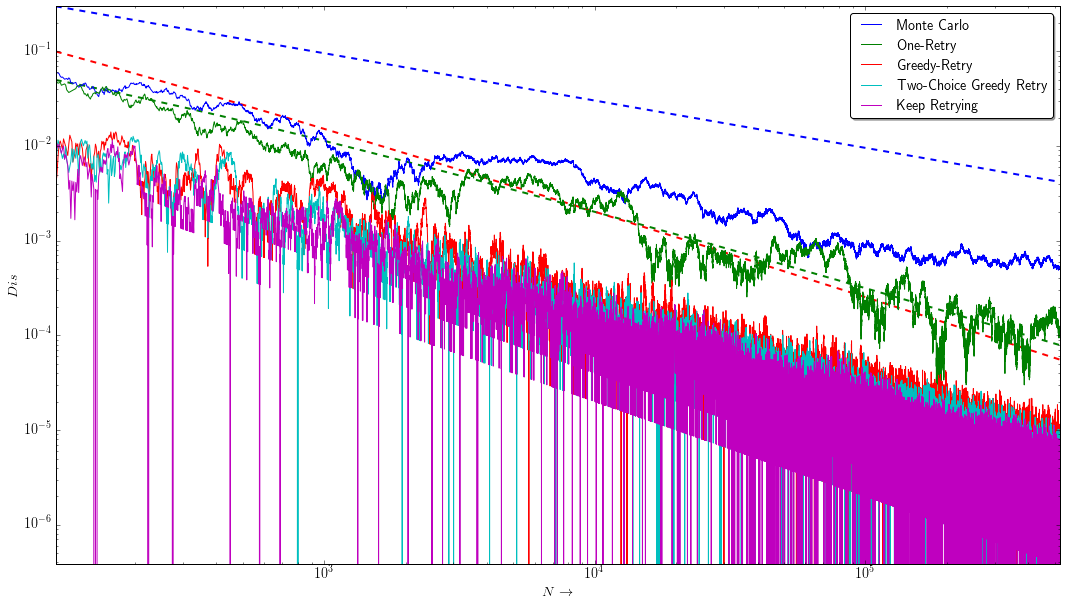

In [300]:
# Plotting Discrepancy
fig = plt.figure(figsize=[18,10])

start_idx = 100
x = avg_n_dis[start_idx:]

# base line:
y0 = np.sqrt(x[0])
y = 0.3*y0 / np.sqrt(x)
plt.plot(x, y, 'b--', linewidth=2.)

y0 = x[0]/(np.log2(x[0])**2)
y = 0.05*y0 /x * ((np.log2(x)**2) )
plt.plot(x, y, 'g--', linewidth=2.)

y0 = x[0]/(np.log2(x[0])**1)
y = 0.1*y0 /x * ((np.log2(x)**1) )
plt.plot(x, y, 'r--', linewidth=2.)

line, = plt.plot(x, avg_u_dis[start_idx:], 'b', linewidth=1.)
line.set_label('Monte Carlo')
line, = plt.plot(x, avg_my_dis[start_idx:], 'g', linewidth=1.)
line.set_label('One-Retry')
line, = plt.plot(x, avg_g_dis[start_idx:], 'r', linewidth=1.)
line.set_label('Greedy-Retry')
line, = plt.plot(x, avg_t_dis[start_idx:], 'c', linewidth=1.)
line.set_label('Two-Choice Greedy Retry')
line, = plt.plot(x, avg_k_dis[start_idx:], 'm', linewidth=1.)
line.set_label('Keep Retrying')

# plt.fill_between(avg_n_dis, avg_u_dis-std_u_dis, avg_u_dis+std_u_dis, facecolor='b',  alpha=0.25)

# plt.fill_between(avg_n_dis, avg_my_dis-std_my_dis, avg_my_dis+std_my_dis, facecolor='g',  alpha=0.25)

# plt.fill_between(avg_n_dis, avg_g_dis-std_g_dis, avg_g_dis+std_g_dis, facecolor='r',  alpha=0.25)

# plt.fill_between(avg_n_dis, avg_t_dis-std_t_dis, avg_t_dis+std_t_dis, facecolor='c',  alpha=0.25)

# plt.fill_between(avg_n_dis, avg_k_dis-std_k_dis, avg_k_dis+std_k_dis, facecolor='m',  alpha=0.25)


plt.yscale('log')
plt.xscale('log')
# plt.title('Comparison of Discrepancy for [0, 0.5) %d dimensions' % dim)
plt.xlabel(r'$N$')
plt.ylabel(r'$\text{Dis}$')
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=0.5)
plt.axis('tight')
plt.show()
# fig.savefig('../../plots/1d/1d-rates-1-2.png')



# ######### Now interval 2

# fig = plt.figure(figsize=[18,10])

# # base line:
# y0 = np.sqrt(avg_n_dis[0])
# y = 0.3*y0 / np.sqrt(avg_n_dis)
# plt.plot(avg_n_dis, y, 'b--', linewidth=2.)

# y0 = avg_n_dis[0]/(np.log2(avg_n_dis[0])**2)
# y = 0.05*y0 /avg_n_dis * ((np.log2(avg_n_dis)**2) )
# plt.plot(avg_n_dis, y, 'g--', linewidth=2.)


# y0 = avg_n_dis[0]/(np.log2(avg_n_dis[0])**1)
# y = 0.1*y0 /avg_n_dis * ((np.log2(avg_n_dis)**1) )
# plt.plot(avg_n_dis, y, 'r--', linewidth=2.)


# line, = plt.plot(avg_n_dis, avg_u_dis2, linewidth=1.)
# line.set_label('Monte Carlo')
# line, = plt.plot(avg_n_dis, avg_my_dis2, linewidth=1.)
# line.set_label('One-Retry')
# line, = plt.plot(avg_n_dis, avg_g_dis2, linewidth=1.)
# line.set_label('Greedy-Retry')
# line, = plt.plot(avg_n_dis, avg_t_dis2, linewidth=1.)
# line.set_label('Two-Choice Greedy-Retry')
# line, = plt.plot(avg_n_dis, avg_k_dis2, linewidth=1.)
# line.set_label('Keep Retrying')

# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel(r'$N \rightarrow$')
# plt.ylabel(r'$\text{Dis}$')
# # plt.title('Comparison of Discrepancy for [1/3, 2/3]')
# plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=0.5)
# plt.axis('tight')

# # fig.savefig('../../plots/1d/1d-rates-1-3.png')

# plt.show()


######### Now Worst Case





In [383]:
import matplotlib as mpl
label_size = 60
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['legend.fontsize'] = 50
pylab.rcParams['xtick.major.pad']=8
pylab.rcParams['ytick.major.pad']=8


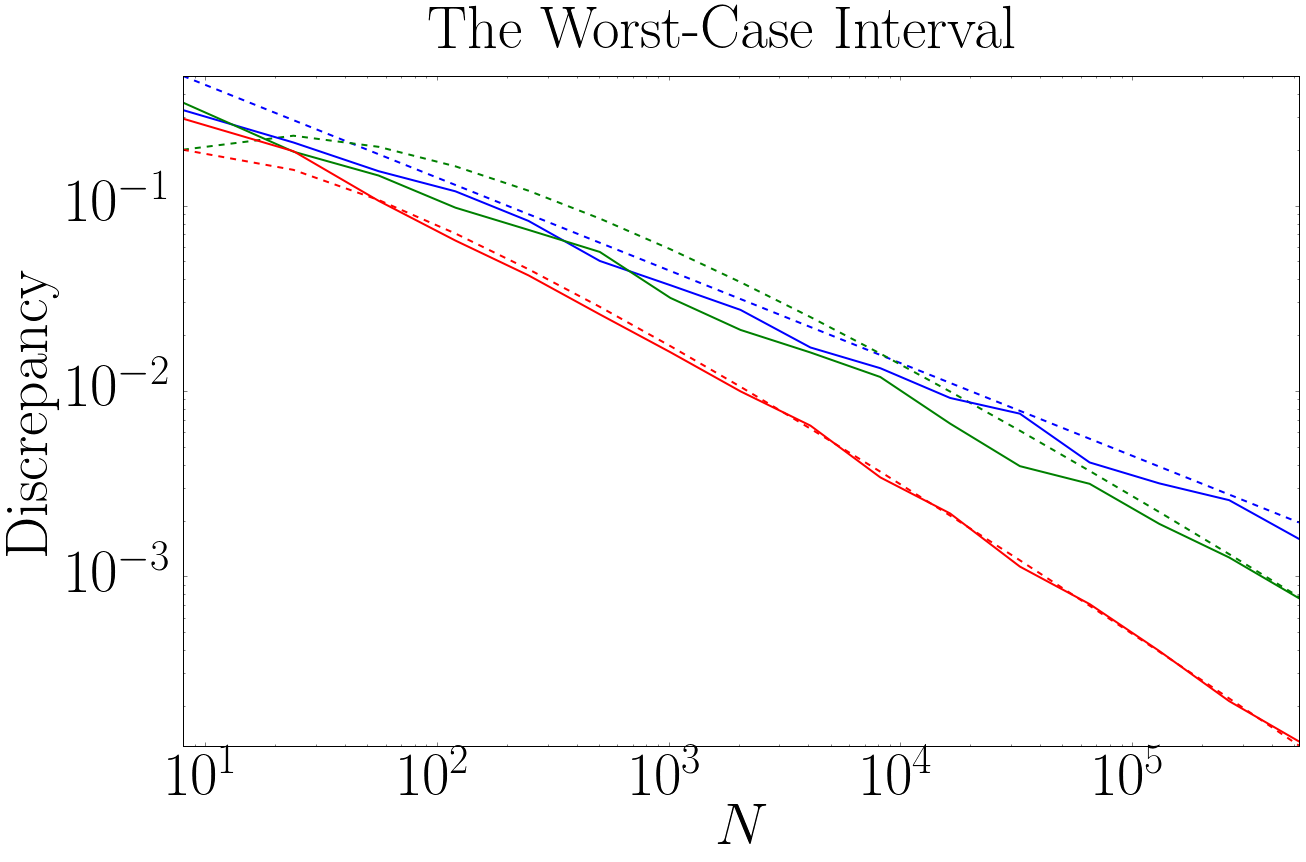

In [389]:
# fig = plt.figure(figsize=[18,10])
fig = plt.figure(figsize=[20,12])


# base line:
y0 = 0.5*np.sqrt(avg_n_w[0])
y = y0 / np.sqrt(avg_n_w)
plt.plot(avg_n_w, y, 'b--', linewidth=2.)

y0 = 0.2*avg_n_w[0]/(np.log2(avg_n_w[0])**3)
y = y0 /avg_n_w * ((np.log2(avg_n_w)**3) )
plt.plot(avg_n_w, y, 'g--', linewidth=2.)


y0 = 0.2*avg_n_w[0]/(np.log2(avg_n_w[0])**2)
y = y0 /avg_n_w * ((np.log2(avg_n_w)**2) )
plt.plot(avg_n_w, y, 'r--', linewidth=2.)


line, = plt.plot(avg_n_w, avg_m_w, 'b', linewidth=2.)
line.set_label('Monte Carlo')
line, = plt.plot(avg_n_w, avg_r_w, 'g', linewidth=2.)
line.set_label('One-Retry')
line, = plt.plot(avg_n_w, avg_g_w, 'r', linewidth=2.)
line.set_label('Greedy-Retry')
# line, = plt.plot(avg_n_w, avg_t_w, 'c', linewidth=2.)
# line.set_label('Two-Choice Greedy-Retry')
# line, = plt.plot(avg_n_w, avg_k_w, 'm', linewidth=2.)
# line.set_label('Forever-Retry')


# plt.fill_between(avg_n_w, avg_m_w, avg_m_w+2*std_m_w, facecolor='blue',  alpha=0.25)

# plt.fill_between(avg_n_w, avg_r_w, avg_r_w+2*std_r_w, facecolor='green',  alpha=0.25)

# plt.fill_between(avg_n_w, avg_g_w, avg_g_w+2*std_g_w, facecolor='red',  alpha=0.25)

# plt.fill_between(avg_n_w, avg_t_w, avg_t_w+2*std_t_w, facecolor='cyan',  alpha=0.25)

# plt.fill_between(avg_n_w, avg_k_w, avg_k_w+2*std_k_w, facecolor='magenta',  alpha=0.25)

# line, = plt.plot(avg_n_dis, avg_k_dis2, linewidth=1.)
# line.set_label('Keep Retrying')

plt.yscale('log')
plt.xscale('log')
# plt.ylabel(r'Discrepancy')
# plt.title('Worst Case Discrepancy')
# plt.legend(loc='lower left', frameon=True, fancybox=True, shadow=0.5)
plt.axis('tight')

ax = fig.gca()
ax.set_ylabel(r'Discrepancy', fontsize = 60, labelpad=8)
ax.set_xlabel(r'$N', fontsize = 60, labelpad=-5)
plt.suptitle(r'The Worst-Case Interval', fontsize=60)



fig.savefig('../../plots/1d/1d-worst-case.pdf')

plt.show()





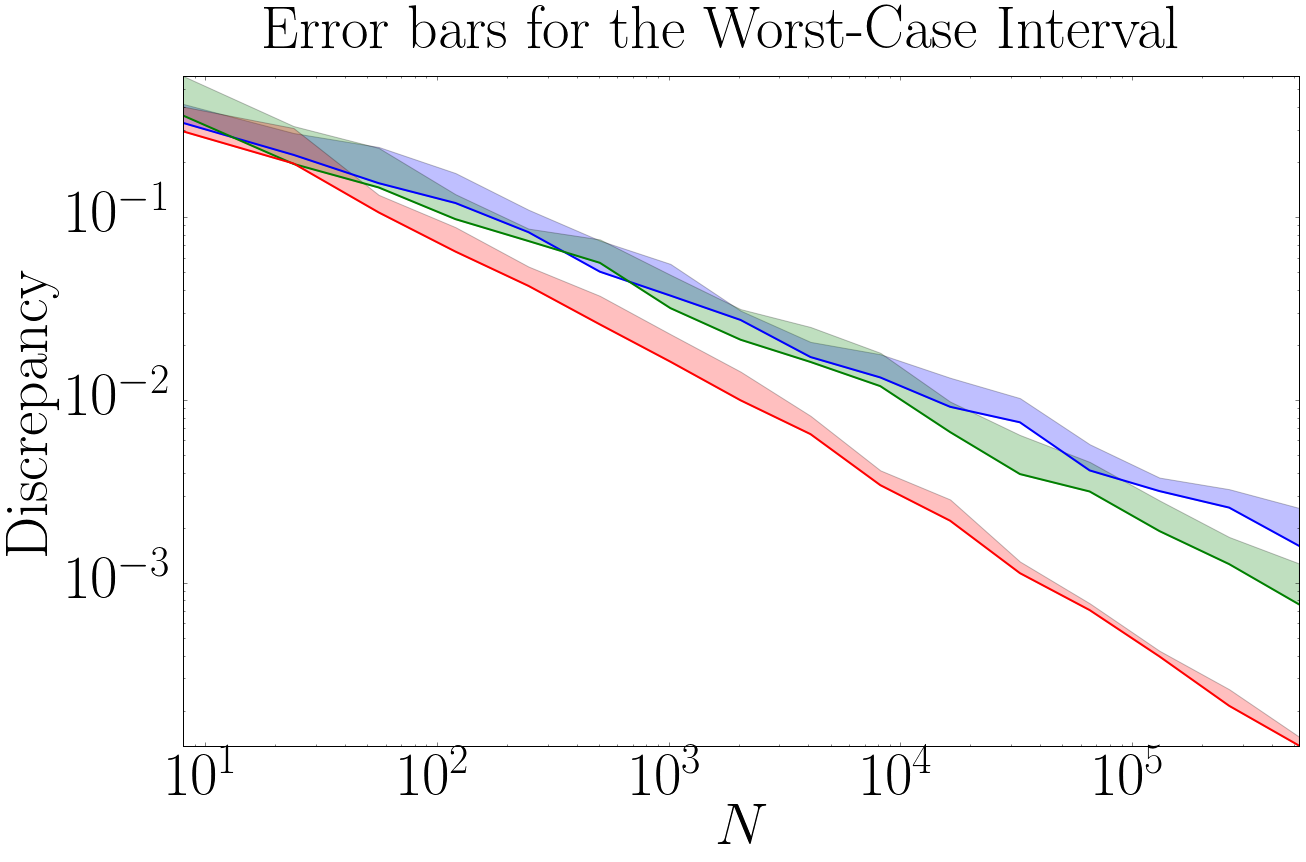

In [388]:
# fig = plt.figure(figsize=[18,10])
fig = plt.figure(figsize=[20,12])


# base line:
# y0 = 0.5*np.sqrt(avg_n_w[0])
# y = y0 / np.sqrt(avg_n_w)
# plt.plot(avg_n_w, y, 'b--', linewidth=2.)

# y0 = 0.5*avg_n_w[0]/(np.log2(avg_n_w[0])**2.5)
# y = y0 /avg_n_w * ((np.log2(avg_n_w)**2.5) )
# plt.plot(avg_n_w, y, 'g--', linewidth=2.)


# y0 = 0.2*avg_n_w[0]/(np.log2(avg_n_w[0])**2)
# y = y0 /avg_n_w * ((np.log2(avg_n_w)**2) )
# plt.plot(avg_n_w, y, 'r--', linewidth=2.)


line, = plt.plot(avg_n_w, avg_m_w, 'b', linewidth=2.)
line.set_label('Monte Carlo')
line, = plt.plot(avg_n_w, avg_r_w, 'g', linewidth=2.)
line.set_label('One-Retry')
line, = plt.plot(avg_n_w, avg_g_w, 'r', linewidth=2.)
line.set_label('Greedy-Retry')
# line, = plt.plot(avg_n_w, avg_t_w, 'c', linewidth=2.)
# line.set_label('Two-Choice Greedy-Retry')
# line, = plt.plot(avg_n_w, avg_k_w, 'm', linewidth=2.)
# line.set_label('Forever-Retry')


plt.fill_between(avg_n_w, avg_m_w, avg_m_w+2*std_m_w, facecolor='blue',  alpha=0.25)

plt.fill_between(avg_n_w, avg_r_w, avg_r_w+2*std_r_w, facecolor='green',  alpha=0.25)

plt.fill_between(avg_n_w, avg_g_w, avg_g_w+2*std_g_w, facecolor='red',  alpha=0.25)

# plt.fill_between(avg_n_w, avg_t_w, avg_t_w+2*std_t_w, facecolor='cyan',  alpha=0.25)

# plt.fill_between(avg_n_w, avg_k_w, avg_k_w+2*std_k_w, facecolor='magenta',  alpha=0.25)

# line, = plt.plot(avg_n_dis, avg_k_dis2, linewidth=1.)
# line.set_label('Keep Retrying')

plt.yscale('log')
plt.xscale('log')
# plt.ylabel(r'Discrepancy')
# plt.title('Worst Case Discrepancy')
# plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=0.5)
plt.axis('tight')

ax = fig.gca()
ax.set_ylabel(r'Discrepancy', fontsize = 60, labelpad=8)
ax.set_xlabel(r'$N', fontsize = 60, labelpad=-5)
plt.suptitle(r'Error bars for the Worst-Case Interval', fontsize=60)



fig.savefig('../../plots/1d/1d-worst-case-error-bars.pdf')

plt.show()




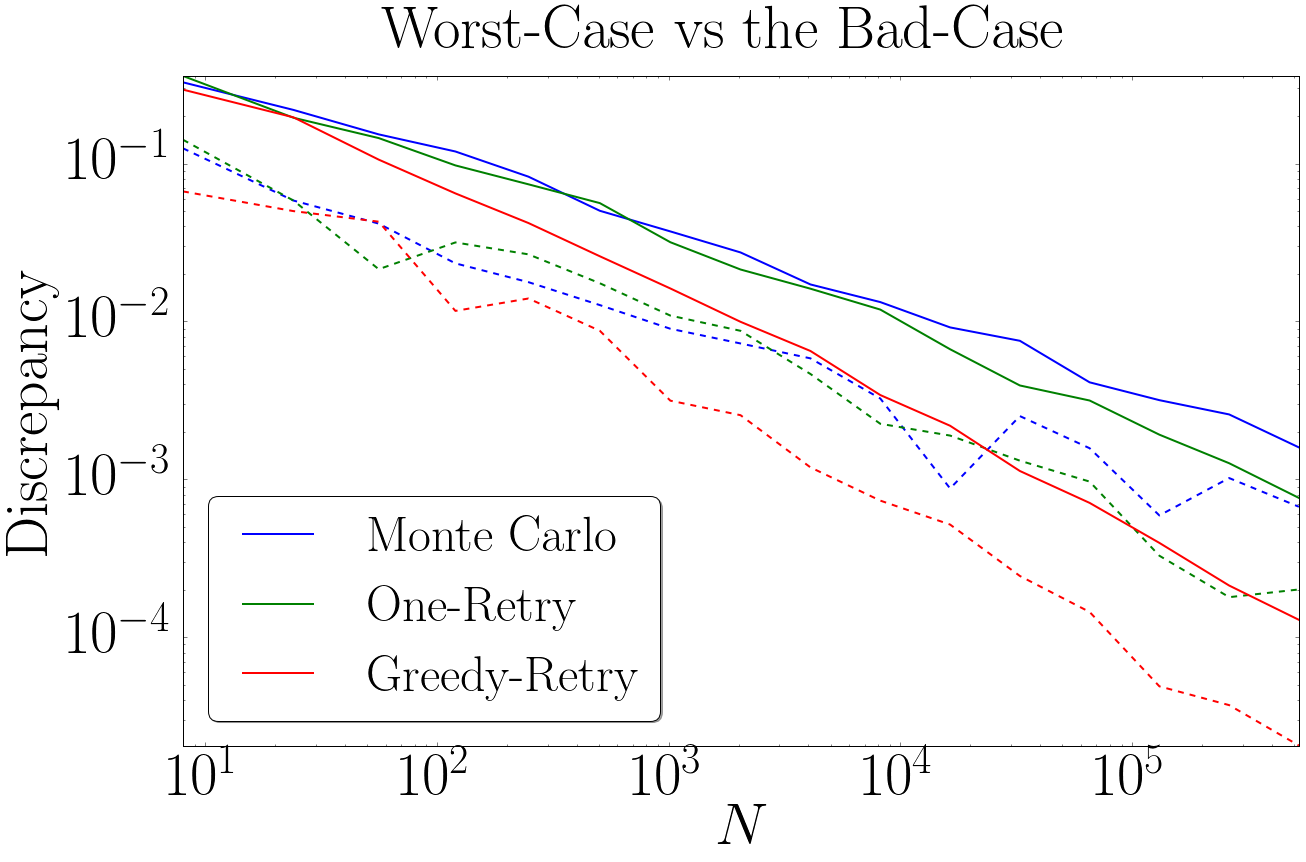

In [420]:
fig = plt.figure(figsize=[20,12])


line, = plt.plot(avg_n_dis[new_mask], avg_u_dis2[new_mask], 'b--', linewidth=2.)

line, = plt.plot(avg_n_dis[new_mask], avg_my_dis2[new_mask], 'g--', linewidth=2.)

line, = plt.plot(avg_n_dis[new_mask], avg_g_dis2[new_mask], 'r--', linewidth=2.)


line, = plt.plot(avg_n_w, avg_m_w, 'b', linewidth=2.)
line.set_label('Monte Carlo')
line, = plt.plot(avg_n_w, avg_r_w, 'g', linewidth=2.)
line.set_label('One-Retry')
line, = plt.plot(avg_n_w, avg_g_w, 'r', linewidth=2.)
line.set_label('Greedy-Retry')

plt.legend(loc='lower left', frameon=True, fancybox=True, shadow=0.5)
plt.axis('tight')


plt.yscale('log')
plt.xscale('log')
ax = fig.gca()
ax.set_ylabel(r'Discrepancy', fontsize = 60, labelpad=8)
ax.set_xlabel(r'$N', fontsize = 60, labelpad=-5)
plt.suptitle(r'Worst-Case vs the Bad-Case', fontsize=60)

plt.show()


fig.savefig('../../plots/1d/1d-worst-vs-bad.pdf')






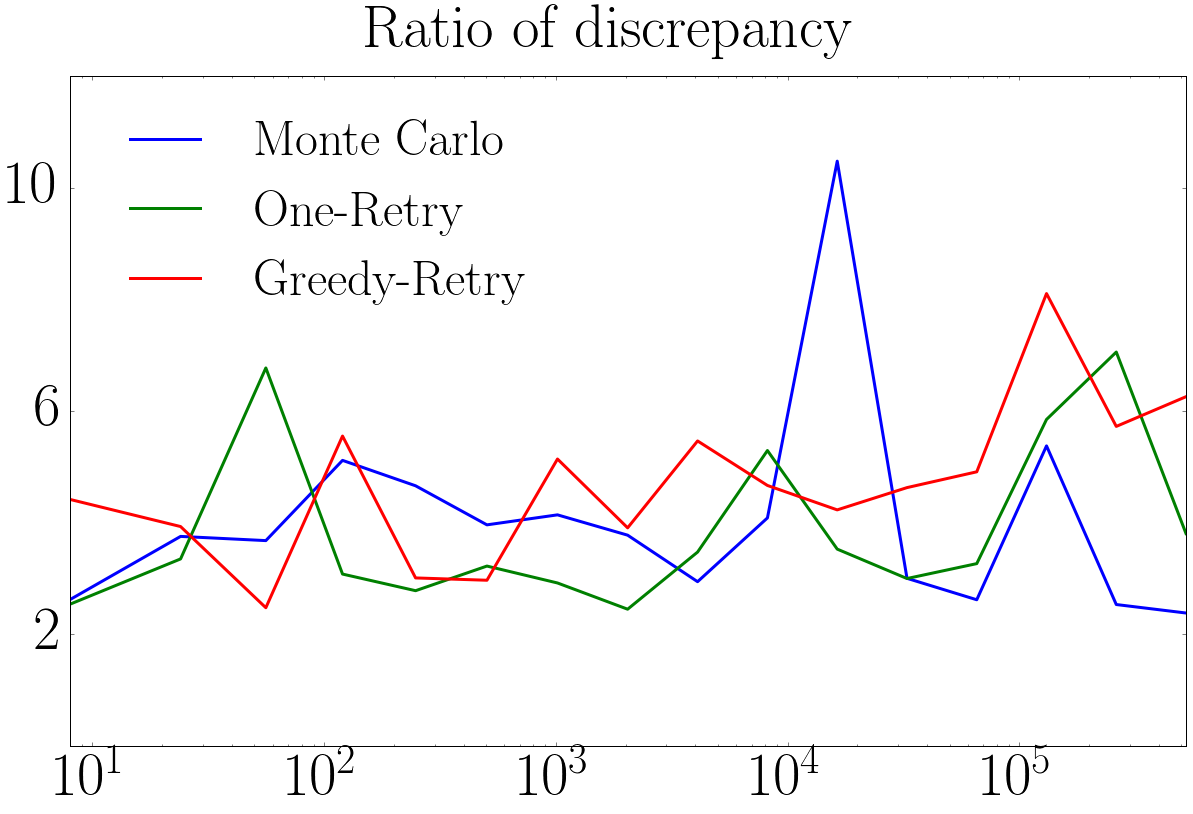

In [413]:
fig = plt.figure(figsize=[20,12])



fig = plt.figure(figsize=[20,12])

start_idx = 0

x = avg_n_dis[start_idx:]

window = 1
end_window = 1
start_window = 0

smooth_m_ratio = np.convolve(avg_m_w/avg_u_dis2[new_mask], np.ones((window,))/window, mode='same')[start_window:]
smooth_r_ratio = np.convolve(avg_r_w/avg_my_dis2[new_mask], np.ones((window,))/window, mode='same')[start_window:]
smooth_g_ratio = np.convolve(avg_g_w/avg_g_dis2[new_mask], np.ones((window,))/window, mode='same')[start_window:]

# line, = plt.plot(avg_n_dis[new_mask], avg_m_w/avg_u_dis2[new_mask], 'b', linewidth=3.)
# line.set_label('Monte Carlo')
# line, = plt.plot(avg_n_dis[new_mask], avg_r_w/avg_my_dis2[new_mask], 'g', linewidth=3.)
# line.set_label('One-Retry')
# line, = plt.plot(avg_n_dis[new_mask], avg_g_w/avg_g_dis2[new_mask], 'r', linewidth=3.)
# line.set_label('Greedy-Retry')

line, = plt.plot(avg_n_dis[new_mask], smooth_m_ratio, 'b', linewidth=3.)
line.set_label('Monte Carlo')
line, = plt.plot(avg_n_dis[new_mask], smooth_r_ratio, 'g', linewidth=3.)
line.set_label('One-Retry')
line, = plt.plot(avg_n_dis[new_mask], smooth_g_ratio, 'r', linewidth=3.)
line.set_label('Greedy-Retry')

# plt.yscale('log')
plt.xscale('log')
# ax.set_ylabel(r'Discrepancy', fontsize = 60, labelpad=8)
ax.set_xlabel(r'$N', fontsize = 60, labelpad=-5)
plt.suptitle(r'Ratio of discrepancy', fontsize=60)

plt.legend(loc='upper left', frameon=False, fancybox=False, shadow=0.5)
plt.axis('tight')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,12))
plt.yticks([2, 6, 10])

fig.savefig('../../plots/1d/1d-ratio-worst-vs-bad.pdf')

plt.show()



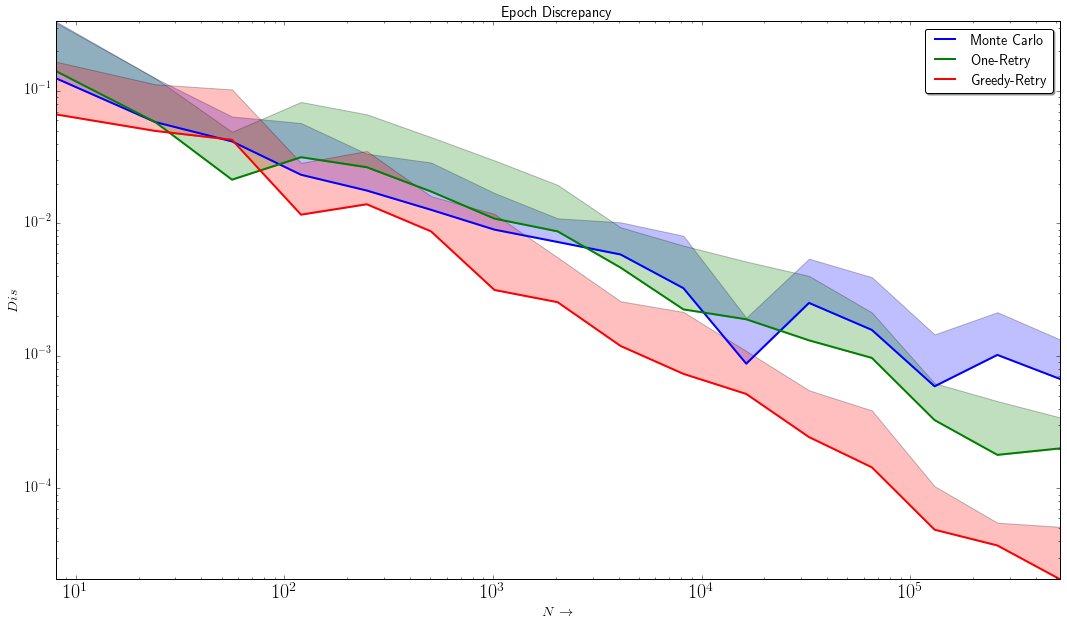

In [346]:
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 


fig = plt.figure(figsize=[18,10])

start_idx = 8
x = avg_n_dis[start_idx:]


# base line:
# y0 = 0.5*np.sqrt(avg_n_w[0])
# y = y0 / np.sqrt(avg_n_w)
# plt.plot(avg_n_w, y, 'b--', linewidth=2.)

# y0 = 0.5*avg_n_w[0]/(np.log2(avg_n_w[0])**2.5)
# y = y0 /avg_n_w * ((np.log2(avg_n_w)**2.5) )
# plt.plot(avg_n_w, y, 'g--', linewidth=2.)


# y0 = 0.2*avg_n_w[0]/(np.log2(avg_n_w[0])**2)
# y = y0 /avg_n_w * ((np.log2(avg_n_w)**2) )
# plt.plot(avg_n_w, y, 'r--', linewidth=2.)

new_n = avg_n_dis[new_mask]

epoch_u_dis2 = avg_u_dis2[new_mask]
epoch_std_u_dis2 = std_u_dis2[new_mask]

epoch_my_dis2 = avg_my_dis2[new_mask]
epoch_std_my_dis2 = std_my_dis2[new_mask]

epoch_g_dis2 = avg_g_dis2[new_mask]
epoch_std_g_dis2 = std_g_dis2[new_mask]

line, = plt.plot(new_n, epoch_u_dis2, 'b', linewidth=2.)
line.set_label('Monte Carlo')
line, = plt.plot(new_n, epoch_my_dis2, 'g', linewidth=2.)
line.set_label('One-Retry')
line, = plt.plot(new_n, epoch_g_dis2, 'r', linewidth=2.)
line.set_label('Greedy-Retry')

plt.fill_between(new_n, epoch_u_dis2, epoch_u_dis2+2*epoch_std_u_dis2, facecolor='blue',  alpha=0.25)

plt.fill_between(new_n, epoch_my_dis2, epoch_my_dis2+2*epoch_std_my_dis2, facecolor='green',  alpha=0.25)

plt.fill_between(new_n, epoch_g_dis2, epoch_g_dis2+2*epoch_std_g_dis2, facecolor='red',  alpha=0.25)

# line, = plt.plot(avg_n_dis, avg_k_dis2, linewidth=1.)
# line.set_label('Keep Retrying')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$N \rightarrow$')
plt.ylabel(r'$\text{Dis}$')
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=0.5)
plt.axis('tight')
plt.title('Epoch Discrepancy')
# fig.savefig('../../plots/1d/1d-rates-1-3.png')

plt.show()






In [336]:
def cumsum(a):
    n = len(a)
    v = np.zeros(n)
    v[0] = a[0]
    for i in range(1, n):
        v[i] = v[i-1] + a[i]
    return v.astype(int)
mask = np.asarray([2**j for j in range(initial_depth, initial_depth+num_depths)])-2
print mask
print avg_n_dis[mask]
print cumsum(avg_n_dis[mask])
print avg_n_w

new_mask = cumsum(avg_n_dis[mask])-2
print avg_n_dis[new_mask]

[     6     14     30     62    126    254    510   1022   2046   4094
   8190  16382  32766  65534 131070 262142]
[  8.00000000e+00   1.60000000e+01   3.20000000e+01   6.40000000e+01
   1.28000000e+02   2.56000000e+02   5.12000000e+02   1.02400000e+03
   2.04800000e+03   4.09600000e+03   8.19200000e+03   1.63840000e+04
   3.27680000e+04   6.55360000e+04   1.31072000e+05   2.62144000e+05]
[     8     24     56    120    248    504   1016   2040   4088   8184
  16376  32760  65528 131064 262136 524280]
[  8.00000000e+00   2.40000000e+01   5.60000000e+01   1.20000000e+02
   2.48000000e+02   5.04000000e+02   1.01600000e+03   2.04000000e+03
   4.08800000e+03   8.18400000e+03   1.63760000e+04   3.27600000e+04
   6.55280000e+04   1.31064000e+05   2.62136000e+05   5.24280000e+05]
[  8.00000000e+00   2.40000000e+01   5.60000000e+01   1.20000000e+02
   2.48000000e+02   5.04000000e+02   1.01600000e+03   2.04000000e+03
   4.08800000e+03   8.18400000e+03   1.63760000e+04   3.27600000e+04
   6.5528

In [ ]:
# import pickle

# with open('1d_dis_and_rvs.pickle', 'w') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([root.rvs, g_root.rvs, t_root.rvs, avg_my_dis, avg_u_dis, 
#                  avg_g_dis, avg_t_dis, avg_my_dis2, avg_u_dis2, 
#                  avg_g_dis2, avg_t_dis2, avg_n_dis], f)


In [ ]:
# # # Load the results
# with open('2d_dis_and_rvs.pickle') as f:  # Python 3: open(..., 'rb')
#     [r_rvs, g_rvs, t_rvs, avg_my_dis, avg_u_dis, 
#     avg_g_dis, avg_t_dis, avg_my_dis2, avg_u_dis2, 
#     avg_g_dis2, avg_t_dis2, avg_n_dis]  = pickle.load(f)


# Worst Case

In [169]:
def worst_discrepancy_with_end_points(n, rvs, interval=np.array([0., 1.])):
    '''
    sorting the list, and then finding discrepancy with and without two end points.
    '''
    sorted_rvs = np.sort(np.asarray(rvs))
    # the list is now (a, ..., b)

    
    L = interval[0] # Left_end_point
    R = interval[1] # Right_end_point
    dis = 0. # discrepancy
    S = -1. # Sign of discrepancy
    p_L = 0.
    p_R = 0.
    p_dis = 0.
    
    nr = len(sorted_rvs)
    if nr==0:
        return dis, S, L, R, float(p_L), float(p_R), float(p_dis)
    
    assert(L<=sorted_rvs[0])
    assert(R>=sorted_rvs[-1])
    # first handling the corner cases

    # [interval[0], a] vs [interval[0], a)
    c_dis = 1./n - (sorted_rvs[0]-interval[0])
    o_dis = sorted_rvs[0]-interval[0]
    if  c_dis > dis  and c_dis > o_dis: # [L, a] wins
        dis = c_dis
        S = 1.
        L = interval[0]
        R = sorted_rvs[0]
        p_L = 0.
        p_R = nr-1
        p_dis = 1.
    elif o_dis > dis: # [L, a) wins
        dis = sorted_rvs[0]-L
        S = -1.
        L = interval[0]
        R = sorted_rvs[0]
        p_L = 0.
        p_R = nr
        p_dis = 0.

    # [b, interval[1]] vs (b, interval[1]]
    c_dis = 1./n-(interval[1]-sorted_rvs[-1])
    o_dis =  interval[1]-sorted_rvs[-1]
    if  c_dis > dis  and c_dis > o_dis:
        dis = c_dis
        L = sorted_rvs[-1]
        R = interval[1]
        S = 1.
        p_L  = nr-1
        p_R = 0.
        p_dis = 1.
    elif o_dis > dis:
        dis = o_dis
        L = sorted_rvs[-1]
        R = interval[1]
        S = -1.
        p_L = nr
        p_R = 0.
        p_dis = 0.
    
    for i, r1 in enumerate(sorted_rvs):
        for j, r2 in enumerate(sorted_rvs[i+1:]):
            c_dis = 1./n * (j+2) - (r2-r1)
            o_dis = (r2-r1) - 1./n * (j+2-2)
            if c_dis > dis and  c_dis > o_dis:
                dis = c_dis
                L = r1
                R = r2
                S = 1.
                p_L = i
                p_R = nr-(i+j+2)
                p_dis = j+2
            elif o_dis > dis:
                dis = o_dis
                L = r1
                R = r2
                S = -1.
                p_L = i+1
                p_R = nr-(i+1+j)
                p_dis =  j
                
    return dis, S, L, R, float(p_L), float(p_R), float(p_dis)

In [170]:
W1 = worst_discrepancy_with_end_points(4, [0.1, 0.4], interval = np.array([0.,0.5]))
print W1
W2 = worst_discrepancy_with_end_points(4, [0.6, 0.67], interval = np.array([0.5, 1.]))
print W2

W_12 = worst_of_two(4, W1, W2)
print W_12

(0.30000000000000004, -1.0, 0.10000000000000001, 0.40000000000000002, 1.0, 1.0, 0.0)
(0.42999999999999994, 1.0, 0.59999999999999998, 0.67000000000000004, 0.0, 0.0, 2.0)
(0.42999999999999994, 1.0, 0.59999999999999998, 0.67000000000000004, 2.0, 0.0, 2.0)


In [184]:
def worst_of_two(n, W1 , W2):
    if n == 0:
        return W1
    dis1, S1, L1, R1, pL1, pR1, pD1 = W1
    dis2, S2, L2, R2, pL2, pR2, pD2 = W2
#     assert(pL1 + pR1 + pD1 == n)
#     assert(pL2 + pR2 + pD2 == n)
    
    # Refer to notability worst case notes for the notation
    if S1 > 0 and S2 > 0:
        c1 = dis1
        c3 = dis2
        if c1 > c3:
            dis = c1
            L, R, S, p_L, p_R, p_dis = L1, R1, S1, pL1, pR1+pL2+pD2+pR2, pD1
        else:
            dis = c3
            L, R, S, p_L, p_R, p_dis = L2, R2, S2, pL1+pD1+pR1+pL2, pR2, pD2
        
        c2 = (L2-R1)-(pR1+pL2)/n
        if c2 > dis:
            dis = c2
            L, R, S, p_L, p_R, p_dis = R1, L2, -1., pL1+pD1, pD2+pR2, pR1+pL2
        
        c4 = (pD1+pR1+pL2+pD2)/n - (R2-L1)
        if c4 > dis:
            dis = c4
            L, R, S, p_L, p_R, p_dis = L1, R2, 1., pL1, pR2, pD1+pR1+pL2+pD2
    
    if S1<0 and S2<0:
        c1 = dis1
        c3 = dis2
        if c1>c3:
            dis = c1
            L, R, S, p_L, p_R, p_dis = L1, R1, S1, pL1, pR1+pL2+pD2+pR2, pD1
        else:
            dis = c3
            L, R, S, p_L, p_R, p_dis = L2, R2, S2, pL1+pD1+pR1+pL2, pR2, pD2
        
        c2 = (pR1+pL2)/n - (L2-R1)
        if c2> dis:
            dis = c2
            L, R, S, p_L, p_R, p_dis = R1, L2, 1., pL1+pD1, pD2+pR2, pR1+pL2
        
        c4 = R2-L1 - (pD1+pR1+pL2+pD2)/n
        if c4> dis:
            dis = c4
            L, R, S, p_L, p_R, p_dis = L1, R2, -1., pL1, pR2, pD1+pR1+pL2+pD2
    
    if S1>0 and S2<0:
        c1 = dis1
        c3 = dis2
        if c1>c3:
            dis = c1
            L, R, S, p_L, p_R, p_dis = L1, R1, S1, pL1, pR1+pL2+pD2+pR2, pD1
        else:
            dis = c3
            L, R, S, p_L, p_R, p_dis = L2, R2, S2, pL1+pD1+pR1+pL2, pR2, pD2
        
        c2 = (pD1+pR1+pL2)/n - L2-L1
        if c2>dis:
            dis = c2
            L, R, S, p_L, p_R, p_dis = L1, L2, 1., pL1, pD2+pR2, pD1+pR1+pL2
        
        c4 = R2-R1 - (pR1+pL2+pD2)/n
        if c4>dis:
            dis = c4
            L, R, S, p_L, p_R, p_dis = R1, R2, -1., pL1+pD1, pR2, pR1+pL2+pD2
            
    if S1<0 and S2>0:
        c1 = dis1
        c3 = dis2
        if c1>c3:
#             print 'here'
            dis = c1
            L, R, S, p_L, p_R, p_dis = L1, R1, S1, pL1, pR1+pL2+pD2+pR2, pD1
        else:
#             print 'there'
            dis = c3
            L, R, S, p_L, p_R, p_dis = L2, R2, S2, pL1+pD1+pR1+pL2, pR2, pD2
      
        c2 =  L2-L1 - (pD1+pR1+pL2)/n
        if c2>dis:
#             print 'why'
            dis = c2
            L, R, S, p_L, p_R, p_dis = L1, L2, -1., pL1, pD2+pR2, pD1+pR1+pL2
        
        c4 = (pR1+pL2+pD2)/n - R2-R1
        if c4>dis:
#             print 'why not'
            dis = c4
            L, R, S, p_L, p_R, p_dis = R1, R2, 1., pL1+pD1, pR2, pR1+pL2+pD2
    W12  = dis, S, L, R, p_L, p_R, p_dis
    assert(np.sum(W12[-3:]) == np.sum(W1[-3:]) + np.sum(W2[-3:]))
    return W12

In [194]:
def tree_traversal_for_worst_case(depth, tree):
    n = len(tree.rvs)
    num_leaves = len(tree.leaves)
    
    for leaf in tree.leaves:
        rvs = leaf.rvs
        leaf_interval = np.array([leaf.lval, leaf.rval])
        leaf.worst_interval = worst_discrepancy_with_end_points(n, rvs, leaf_interval)
    
    new_leaves = tree.leaves
    j = depth
    
    while (j>0):
        old_leaves = new_leaves
        new_leaves = []
#         print j
#         print ''
        for i, leaf in enumerate(old_leaves):
            if i%2 == 0:
                node  = leaf.parent
                W1 = node.lchild.worst_interval
                W2 = node.rchild.worst_interval
                node.worst_interval = worst_of_two(n, W1, W2)
#                 print leaf.lval, leaf.rval
#                 print node.lval, node.rval
#                 print node.worst_interval[1:4]
#                 print np.sum(node.lchild.worst_interval[-3:]) + np.sum(node.rchild.worst_interval[-3:])
#                 print np.sum(node.worst_interval[-3:])
#                 print ''
                new_leaves.append(node)
        j -=1